<a href="https://colab.research.google.com/github/rloaizam/Visualizacion-Datos/blob/main/PracticaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Cargar Librerías

---



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import io
import requests

#2.Inicialización

---



## 2.1 Adquirir datos

In [3]:
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Cargar el conjunto de datos
url = '/content/drive/MyDrive/Colab Notebooks/Visualizacion/Datos_MPP.csv'
df = pd.read_csv(url, encoding='ISO-8859-1', sep=';', low_memory=False)

##2.2 Explorar datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428602 entries, 0 to 428601
Data columns (total 43 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Negocio           428602 non-null  object 
 1   Mercado           428602 non-null  object 
 2   Segmento          428602 non-null  object 
 3   Pais              428602 non-null  object 
 4   Canal             428602 non-null  object 
 5   SubCanal          428602 non-null  object 
 6   Estado            428602 non-null  object 
 7   Ciudad            428602 non-null  object 
 8   Zona              428602 non-null  object 
 9   Region_Geo        428602 non-null  object 
 10  Division_Geo      428602 non-null  object 
 11  Region_Panam      428602 non-null  object 
 12  Asesor            428602 non-null  object 
 13  Representante     428602 non-null  object 
 14  Clase_Cliente     428602 non-null  object 
 15  Grupo_Cliente     428602 non-null  object 
 16  SubGrupo_Cliente  42

In [6]:
# Convertir columna Fecha a formato dia/mes/año
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')

In [7]:
# Renombramos las columnas
df.rename(columns={'UV': 'Sales_Units', 'USD': 'Sales_USD', 'CEMV': 'COGS', 'COntrib': 'Gross_Margin' }, inplace=True)

# Muestra las primeras 5 filas del DataFrame
df.head(5)

,Negocio,Mercado,Segmento,Pais,Canal,SubCanal,Estado,Ciudad,Zona,Region_Geo,...,Centro,Nmes,Mes,Año,Fecha,Nota,Sales_Units,Sales_USD,COGS,Gross_Margin
0,MPP,NACIONAL,MPP,EE.UU.,RETAIL,RETAIL,ALABAMA,LOXLEY,CENTRAL RETAIL,SOUTHEAST,...,OH,1,Enero,2018,2018-01-01,OK,10.0,23.30,12.62,10.68
1,MPP,NACIONAL,MPP,EE.UU.,RETAIL,RETAIL,ALABAMA,LOXLEY,CENTRAL RETAIL,SOUTHEAST,...,OH,1,Enero,2018,2018-01-01,OK,90.0,6522.30,4644.45,1877.85
2,MPP,NACIONAL,MPP,EE.UU.,RETAIL,RETAIL,ALABAMA,LOXLEY,CENTRAL RETAIL,SOUTHEAST,...,OH,1,Enero,2018,2018-01-01,OK,6.0,178.68,100.92,77.76
3,MPP,NACIONAL,MPP,EE.UU.,RETAIL,RETAIL,ALABAMA,LOXLEY,CENTRAL RETAIL,SOUTHEAST,...,OH,1,Enero,2018,2018-01-01,OK,1.0,18.19,14.13,4.06
4,MPP,NACIONAL,MPP,EE.UU.,RETAIL,RETAIL,ARIZONA,KINGMAN,CENTRAL RETAIL,SOUTHWEST,...,OH,1,Enero,2018,2018-01-01,OK,4.0,308.28,231.50,76.78


# 3.Análisis de ventas (USD, Units, Gross margin)

---



## 3.1 Gráfico de Línea - Evolución del total de ventas y margen

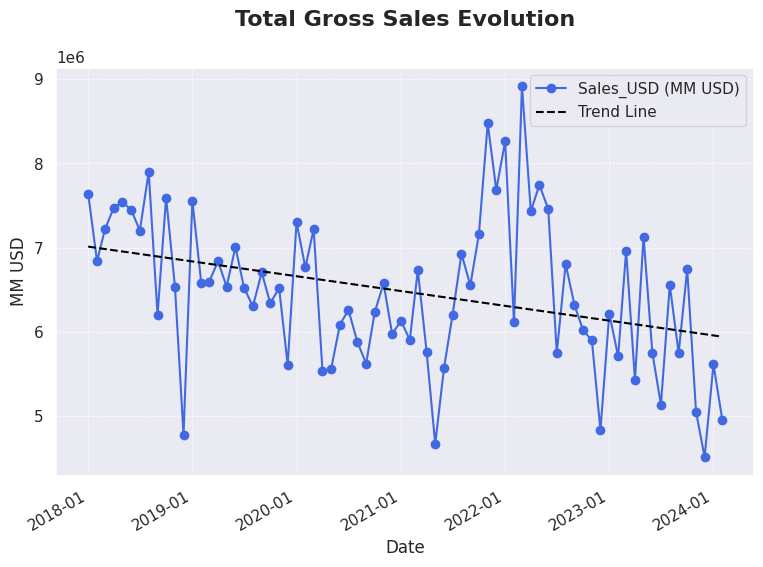

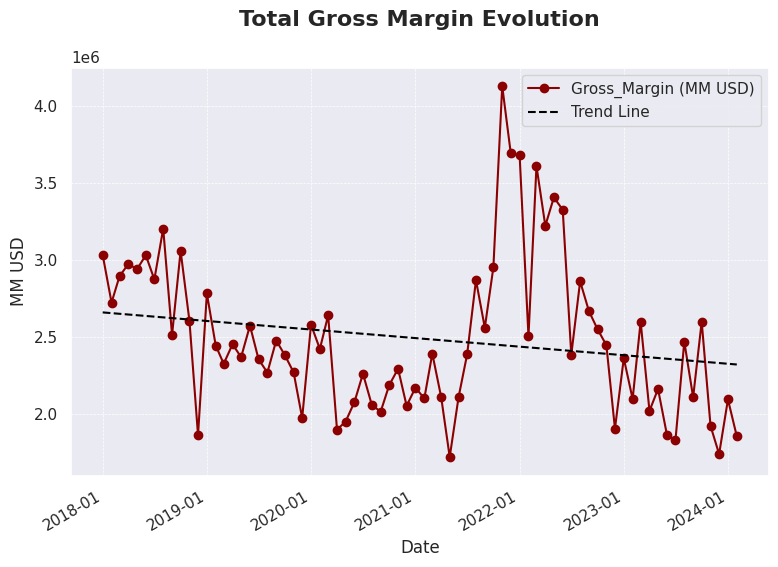

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

def plot_sales_trend(df, column, title):
    # Aplica un estilo de Seaborn
    sns.set_theme(style='darkgrid')

    # Agrupa los datos por 'Fecha' y suma la columna especificada para cada fecha
    sales = df.groupby('Fecha')[column].sum()

    # Prepara las fechas para la línea de tendencia
    dates_ordinal = pd.to_datetime(sales.index).map(pd.Timestamp.toordinal)
    z = np.polyfit(dates_ordinal, sales.values, 1)
    p = np.poly1d(z)

    # Crea el gráfico de líneas y la línea de tendencia
    plt.figure(figsize=(9, 6))
    if column == 'Sales_USD':
        plt.plot(sales.index, sales.values, marker='o', linestyle='-', color='royalblue', label=f'{column} (MM USD)')
    elif column == 'Gross_Margin':
        plt.plot(sales.index, sales.values, marker='o', linestyle='-', color='darkred', label=f'{column} (MM USD)')
    plt.plot(sales.index, p(dates_ordinal), linestyle='--', color='black', label='Trend Line')

    # Configura los detalles del gráfico
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()  # Automaformato para la fecha
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title(title, fontsize=16, fontweight='bold', pad=30)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('MM USD', fontsize=12)
    plt.legend()

    plt.show()

# Ejemplo de uso para graficar las ventas SAles_USD
plot_sales_trend(df, 'Sales_USD', 'Total Gross Sales Evolution')

# Ejemplo de uso para graficar el Gross Margin
plot_sales_trend(df, 'Gross_Margin', 'Total Gross Margin Evolution')



## 3.2 Grafico de Líneas & Decomposed - Evolución de ventas en USD por categoría

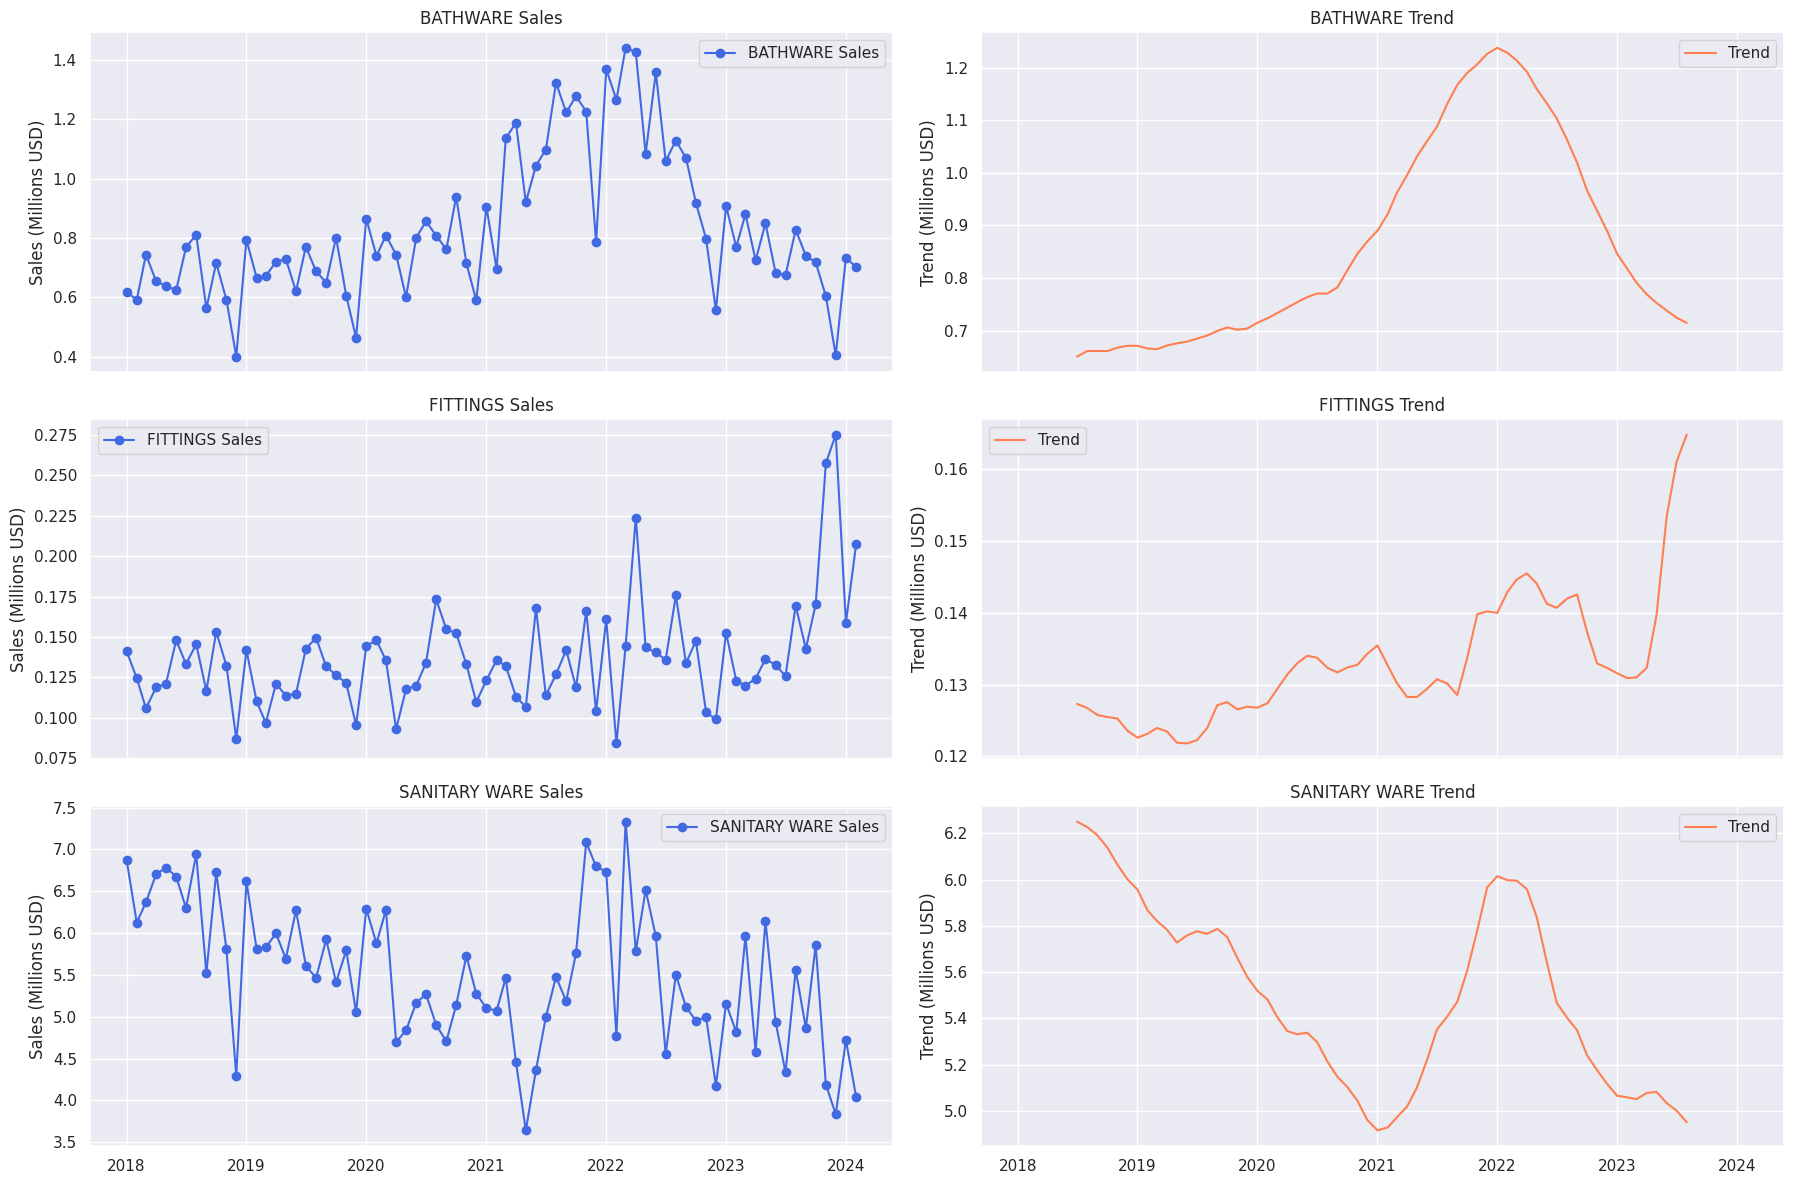

In [57]:
import statsmodels.api as sm

df['Sales_USD_Millions'] = df['Sales_USD'] / 1e6
ventas_por_categoria_fecha = df.groupby(['Fecha', 'Categoria'])['Sales_USD_Millions'].sum().reset_index()

# Establecer el estilo de Seaborn para los gráficos
sns.set_theme(style='darkgrid')

# Obtener una lista de categorías únicas
categorias_unicas = ventas_por_categoria_fecha['Categoria'].unique()

# Configurar la figura y los ejes para los subplots
num_categorias = len(categorias_unicas)
fig, axes = plt.subplots(num_categorias, 2, figsize=(18, 4 * num_categorias), sharex=True)

for i, categoria in enumerate(categorias_unicas):
    df_categoria = ventas_por_categoria_fecha[ventas_por_categoria_fecha['Categoria'] == categoria]
    serie_temporal = df_categoria.set_index('Fecha')['Sales_USD_Millions']

    # Gráfico de ventas reales
    axes[i, 0].plot(serie_temporal.index, serie_temporal.values, marker='o', linestyle='-', color='royalblue', label=f'{categoria} Sales')
    axes[i, 0].set_title(f'{categoria} Sales')
    axes[i, 0].set_ylabel('Sales (Millions USD)')
    axes[i, 0].legend()

    # Gráfico de la tendencia descompuesta
    descomposicion = sm.tsa.seasonal_decompose(serie_temporal, model='additive', period=12)
    axes[i, 1].plot(descomposicion.trend.index, descomposicion.trend, color='coral', label='Trend')
    axes[i, 1].set_title(f'{categoria} Trend')
    axes[i, 1].set_ylabel('Trend (Millions USD)')
    axes[i, 1].legend()

# Ajustar los gráficos
plt.tight_layout()
plt.show()


## 3.3 Escalado de volumen y precio

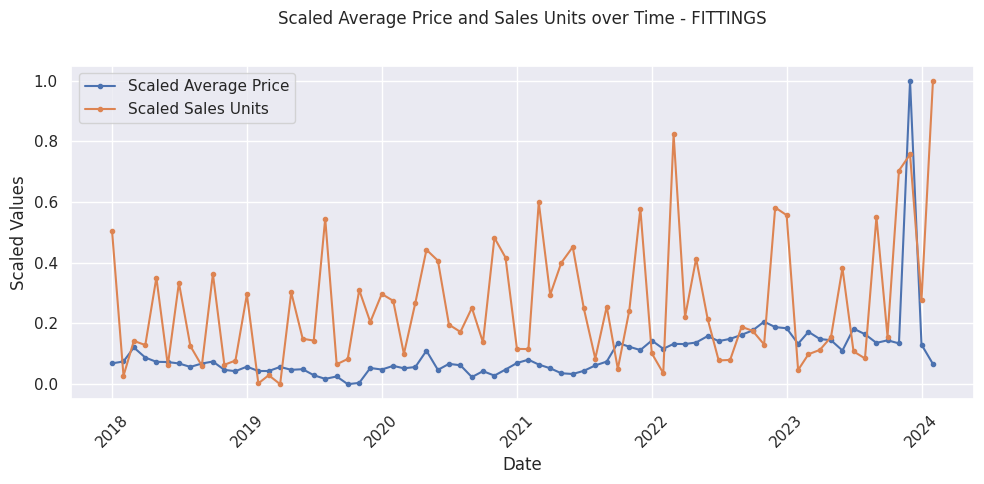

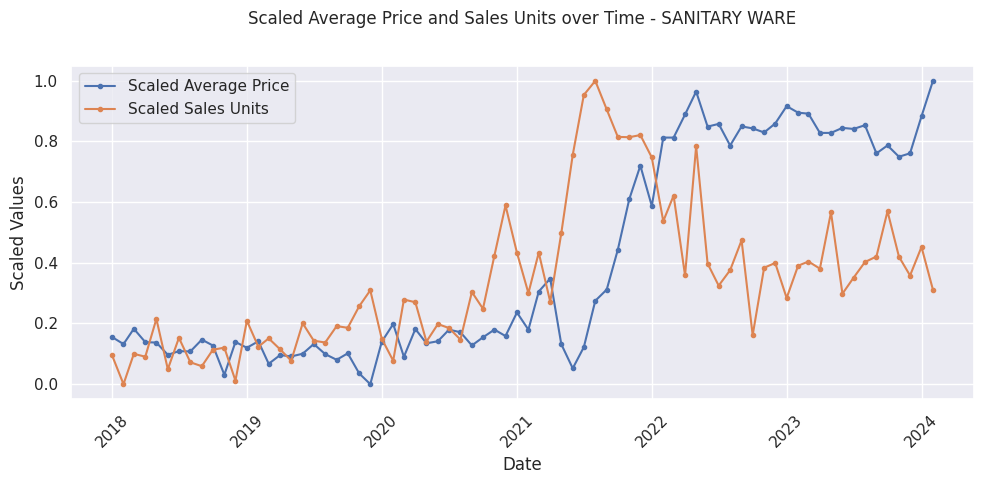

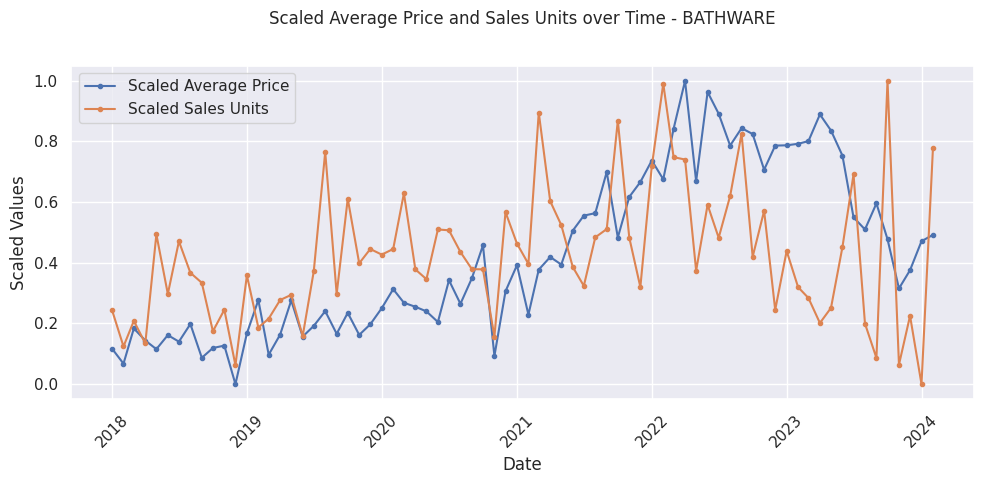

In [74]:
from sklearn.preprocessing import MinMaxScaler

# Crear una lista de todas las categorías únicas
categorias = df['Categoria'].unique()

# Definir una función para graficar para una categoría dada
def plot_category(category):
  category_df = df[(df['Categoria'] == category) & (df['Sales_Units'] > 0)].copy()
  category_df['Precio_Promedio'] = category_df['Sales_USD'] / category_df['Sales_Units']
  grouped_df = category_df.groupby('Fecha').agg({'Sales_Units': 'mean', 'Precio_Promedio': 'mean'}).reset_index()

  # Escalar los valores de precio promedio y Sales_Units entre 0 y 1 utilizando MinMaxScaler
  scaler = MinMaxScaler()
  scaled_values = scaler.fit_transform(grouped_df[['Precio_Promedio', 'Sales_Units']])
  grouped_df['Precio_Promedio_Escalado'], grouped_df['Sales_Units_Escalado'] = scaled_values[:, 0], scaled_values[:, 1]

  # Graficar los resultados
  plt.figure(figsize=(10, 5))
  plt.plot(grouped_df['Fecha'], grouped_df['Precio_Promedio_Escalado'],
           label='Scaled Average Price', marker='o', markersize=3)
  plt.plot(grouped_df['Fecha'], grouped_df['Sales_Units_Escalado'],
           label='Scaled Sales Units', marker='o', markersize=3)
  plt.xlabel('Date')
  plt.ylabel('Scaled Values')
  plt.title(f'Scaled Average Price and Sales Units over Time - {category}', pad=30)
  plt.legend()
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# Iterar sobre todas las categorías y generar las gráficas correspondientes
for categoria in categorias:
    plot_category(categoria)


## 3.4 Matriz de correlación entre categorias

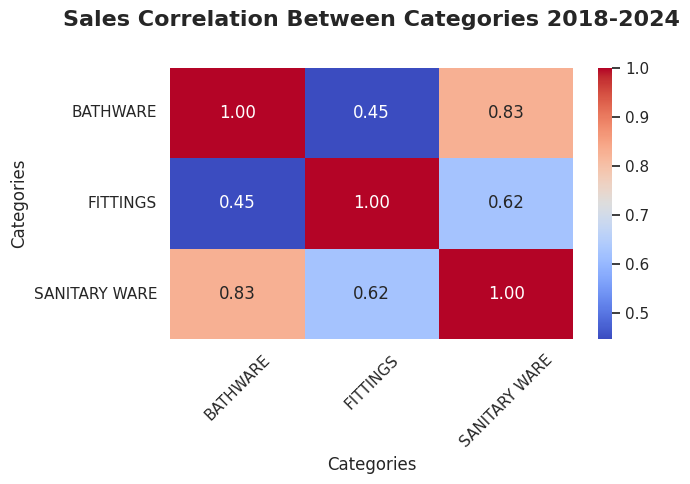

In [11]:
# Filtramos los datos para las categorías de interés y donde Sales_USD sea mayor que 0
categories = ['SANITARY WARE', 'FITTINGS', 'BATHWARE']
filtered_df = df[(df['Categoria'].isin(categories)) & (df['Sales_USD'] > 0)].copy()

# Excluimos las ventas menores o iguales a cero del análisis
filtered_df = filtered_df[filtered_df['Sales_USD'] > 0]

# Calculamos la matriz de correlación entre las ventas de Sales_USD de las categorías seleccionadas
correlation_matrix = filtered_df.pivot_table(index='Fecha', columns='Categoria', values='Sales_USD', aggfunc='mean').corr()

# Creamos el mapa de calor de correlaciones
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Sales Correlation Between Categories 2018-2024',
          fontsize=16, fontweight='bold', pad=30)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Categories', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4.Análisis de Categorias de Producto

## 4.1 Grafico de pastel por Categoría - Evolución bianual

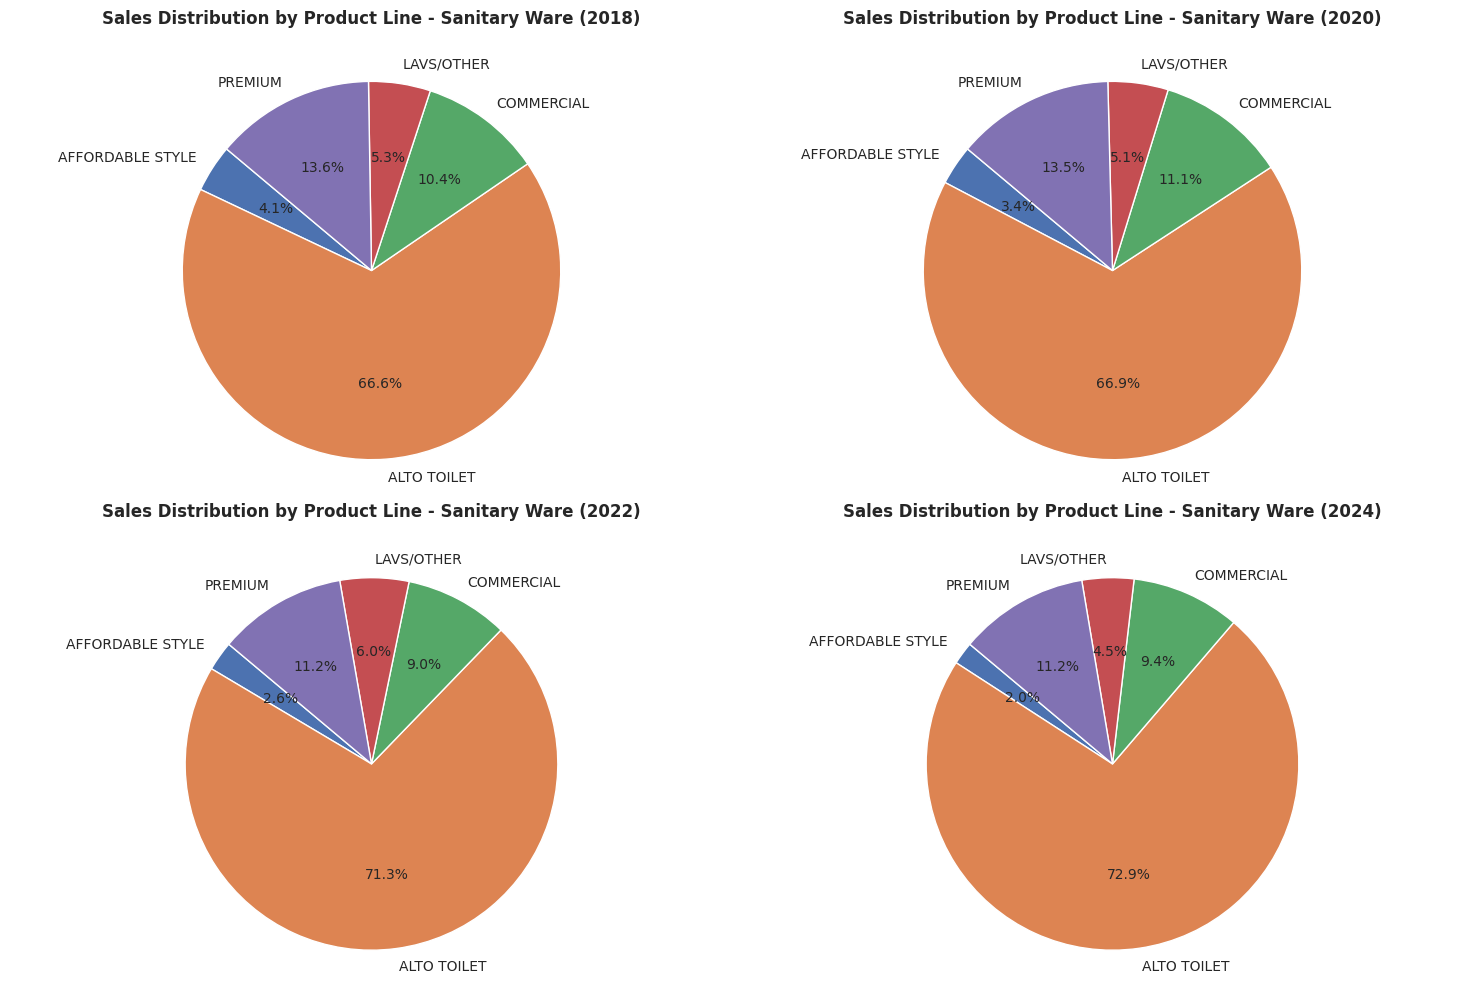

In [69]:
def plot_sanitary_ware(df, year):
    # Filtrar los datos solo para la categoría "Sanitarios" y excluyendo la línea "CHINA ALLOWANCES" para el año dado
    sanitarios_df = df[(df['Categoria'] == 'SANITARY WARE') & (df['Linea'] != 'CHINA ALLOWANCES') & (df['Fecha'].dt.year == year)].copy()

    # Sumar las ventas de las líneas OPP con LAVS/OTHERS
    sanitarios_df.loc[sanitarios_df['Linea'].isin(['OPP', 'LAVS/OTHERS']), 'Linea'] = 'LAVS/OTHERS'

    # Calcula las ventas totales de cada línea en la categoría "Sanitarios"
    line_sales = sanitarios_df.groupby('Linea')['Sales_USD'].sum()

    # Ordena las líneas por sus ventas totales en orden descendente
    sorted_line_sales = line_sales.sort_values(ascending=False)

    # Selecciona las líneas más vendidas (digamos, las 10 principales)
    top_lines = sorted_line_sales.head(10)

    # Crea una nueva columna en el DataFrame original para categorizar las líneas como "Top 10" o "Otros"
    sanitarios_df.loc[:, 'Line_Category'] = sanitarios_df['Linea'].apply(lambda x: x if x in top_lines else 'Otros')

    # Agrupa los datos por la nueva categoría de línea y suma las ventas
    line_category_sales = sanitarios_df.groupby('Line_Category')['Sales_USD'].sum()

    # Excluir la categoría "LAVS/OTHERS" si hay otras categorías
    if len(line_category_sales) > 1:
        line_category_sales.drop('LAVS/OTHERS', inplace=True)

    # Crea el gráfico de pastel
    plt.pie(line_category_sales, labels=line_category_sales.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})

    plt.title(f'Sales Distribution by Product Line - Sanitary Ware ({year})',
              fontsize=12, fontweight='bold', pad=30)
    plt.axis('equal')
    plt.tight_layout()

# Suponiendo que df es tu DataFrame con los datos
years = [2018, 2020, 2022, 2024]

plt.figure(figsize=(15, 10))  # Tamaño del subplot

for i, year in enumerate(years, start=1):
    plt.subplot(2, 2, i)  # Configura el subplot
    plot_sanitary_ware(df, year)

plt.show()


# 5.Análisis de Clientes

## 5.1 Gráfico de Columna - Evolución de clientes por año

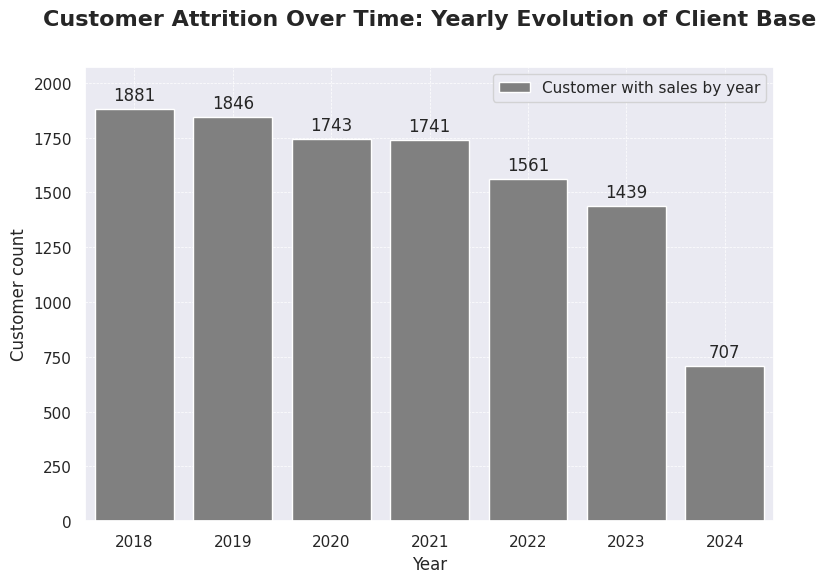

In [13]:
sns.set_theme(style='darkgrid')

# Filtrar los clientes con ventas USD > 0
clientes = df[df['Sales_USD'] > 0].groupby('Año')['Cod_Cliente'].nunique().reset_index()

# Crear el gráfico de columnas
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Año', y='Cod_Cliente', data=clientes,
                      color='gray', label='Customer with sales by year')

# Añadir etiquetas en las columnas para mostrar los valores
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')

# Añadir título y etiquetas
current_top = plt.ylim()[1]  # Obtener el límite superior actual del eje Y
plt.ylim(top=current_top * 1.05)  # Aumentar el límite superior del eje Y

# Añadir títulos, etiquetas y mejorar la visualización
plt.title('Customer Attrition Over Time: Yearly Evolution of Client Base',
          fontsize=16, fontweight='bold', pad=30)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Customer count', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

## 5.2 Gráfico de Línea - Evolución de clientes por mes

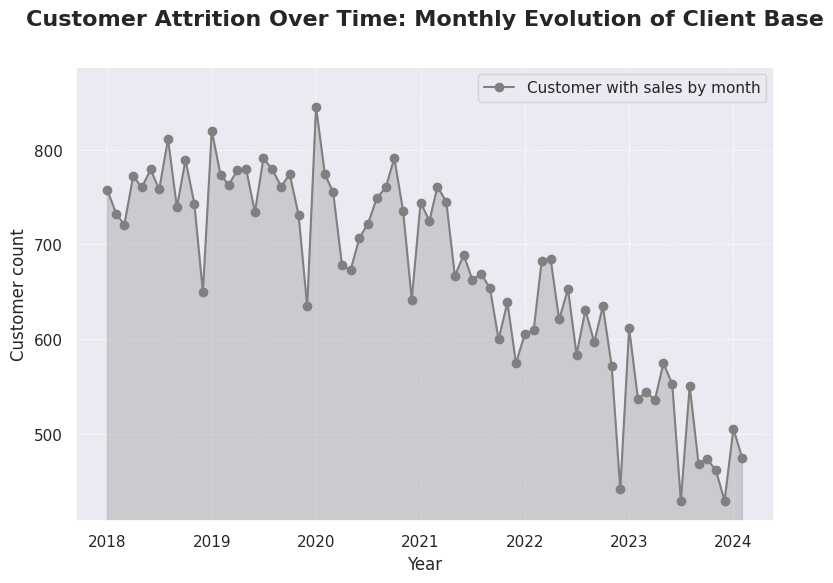

In [14]:
# Filtrar los registros con ventas USD > 0
clientes_mes = df[df['Sales_USD'] > 0]

# Agrupar por 'Fecha' y 'Cod_Cliente', contando clientes únicos por fecha
clientes_por_fecha = clientes_mes.groupby('Fecha')['Cod_Cliente'].nunique()

# Aplica un estilo de Seaborn para la visualización
sns.set_theme(style='darkgrid')

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(clientes_por_fecha.index, clientes_por_fecha.values, marker='o',
         linestyle='-', color='gray', label='Customer with sales by month')

# Añadir el relleno debajo de la línea
plt.fill_between(clientes_por_fecha.index, clientes_por_fecha.values,
                 color='gray', alpha=0.3)  # Ajusta la transparencia con 'alpha'

# Añadir títulos, etiquetas y mejorar la visualización
plt.title('Customer Attrition Over Time: Monthly Evolution of Client Base',
          fontsize=16, fontweight='bold', pad=30)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Customer count', fontsize=12)

# Ajustar el inicio del eje Y
min_value = clientes_por_fecha.values.min()
plt.ylim(min_value * 0.95, clientes_por_fecha.values.max() * 1.05)

# Añadir la leyenda al gráfico
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

## 5.3 Heatmap - Pérdida de clientes por Región Geográfica

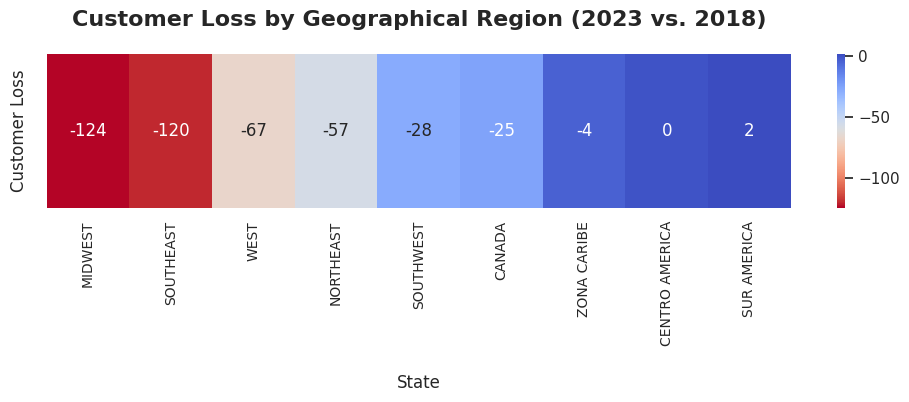

In [71]:
# Combina filtrado, conteo, diferencia y preparación de datos para el heatmap
data_for_heatmap = (
    df[df['Año'].isin([2018, 2023])]
    .groupby(['Region_Geo', 'Año'])['Cod_Cliente'].nunique()
    .unstack()
    .pipe(lambda x: x[2023] - x[2018])
    .sort_values(ascending=True)
    .to_frame().T
)

# Genera el heatmap
plt.figure(figsize=(12, 2))
ax = sns.heatmap(data_for_heatmap, cmap='coolwarm_r', annot=True, fmt=".0f")

ax.set_xlabel('State', fontsize=12, labelpad=20)
ax.tick_params(axis='x', labelsize=10)
ax.set_yticklabels(['' if '0' in label.get_text() else
                    label.get_text() for label in ax.get_yticklabels()])

plt.title('Customer Loss by Geographical Region (2023 vs. 2018)',
          fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Customer Loss', fontsize=12)

plt.show()

## 5.4 Heatmap - Pérdida de clientes por Estado

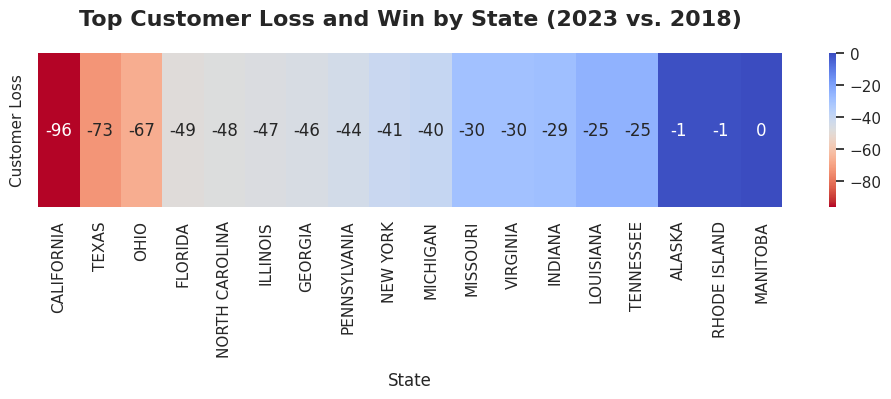

In [73]:
# Combina filtrado, conteo, y diferencia
diferencia_clientes = (
    df[df['Año'].isin([2018, 2024])]
    .groupby(['Estado', 'Año'])['Cod_Cliente'].nunique()
    .unstack()
    .pipe(lambda x: x[2024] - x[2018])
)

# Selecciona los estados con mayor pérdida y ganancia de clientes
top_perdidos = diferencia_clientes.nsmallest(15)
top_ganados = diferencia_clientes.nlargest(3)

# Combina los estados seleccionados
top_cambios = pd.concat([top_perdidos, top_ganados]).sort_values()

# Preparar los datos para el heatmap
data_for_heatmap = top_cambios.to_frame().T

# Genera el heatmap
plt.figure(figsize=(12, 2))
ax = sns.heatmap(data_for_heatmap, cmap='coolwarm_r', annot=True, fmt=".0f")
ax.set_xlabel('State', fontsize=12, labelpad=10)
ax.set_yticklabels(['Customer Loss'])
plt.title('Top Customer Loss and Win by State (2023 vs. 2018)', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('')

plt.show()